## Final Project CSCA 5632
We have collected data for different countries across several metrics both economic, immigration levels, conflict indices, and social progress scores. We are going to analyze countries across these metrics and see if we can identify cluster areas.

In [172]:
import pandas as pd
import glob
import os

import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, 'data')

In [173]:
def import_data(directory):
    # Create a dictionary to store DataFrames
    data_frames = {}

    # Use glob to find all CSV files in the specified directory
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    # Iterate over the list of CSV files and read each one into a DataFrame
    for file in csv_files:
        # Extract the file name without extension to use as the key
        file_name = os.path.splitext(os.path.basename(file))[0]
        df = pd.read_csv(file)
        
        # Store the DataFrame in the dictionary
        data_frames[file_name] = df

        print(f"CSV file {file} has been successfully loaded into a pandas DataFrame.\n")

    return data_frames

data_frames = import_data(data_directory)

master_df = next(iter(data_frames.values()))

# Iterate through the remaining DataFrames and merge them
for df_name, df in list(data_frames.items())[1:]:
    master_df = pd.merge(master_df, df, on='Country', how='outer', suffixes=('', f'_{df_name}'))

master_df.dropna(inplace=True)
# Now 'merged_df' contains all DataFrames joined by the 'Country' column
print("All DataFrames have been merged by Country.")
print(f"Shape of the merged DataFrame: {master_df.shape}")


/tmp/ipykernel_42257/97777738.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


CSV file /home/drodriq/Coursework/CU Boulder/ML/Course2/final_2/data/conflict_index.csv has been successfully loaded into a pandas DataFrame.

CSV file /home/drodriq/Coursework/CU Boulder/ML/Course2/final_2/data/gpi_2022.csv has been successfully loaded into a pandas DataFrame.

CSV file /home/drodriq/Coursework/CU Boulder/ML/Course2/final_2/data/gdp_per_capita_country_2022.csv has been successfully loaded into a pandas DataFrame.

CSV file /home/drodriq/Coursework/CU Boulder/ML/Course2/final_2/data/social_progress_scores.csv has been successfully loaded into a pandas DataFrame.

CSV file /home/drodriq/Coursework/CU Boulder/ML/Course2/final_2/data/countries_by_population_2022.csv has been successfully loaded into a pandas DataFrame.

CSV file /home/drodriq/Coursework/CU Boulder/ML/Course2/final_2/data/net_immigration.csv has been successfully loaded into a pandas DataFrame.

All DataFrames have been merged by Country.
Shape of the merged DataFrame: (139, 23)


In [174]:
# Change Absolute Net Immigrants to immigrants per capita
master_df['Immigrants_per_Capita'] = master_df.apply(lambda row: 0 if row['Absolute Net Immigrants'] == 0 else row['Absolute Net Immigrants'] / row['Population'], axis=1)

# Drop the 'Absolute Net Immigrants' column
master_df = master_df.drop('Absolute Net Immigrants', axis=1)
master_df = master_df.drop('Social Progress Score', axis=1)
master_df = master_df.drop('Population', axis=1)


print(master_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 139 entries, 0 to 331
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Country                                   139 non-null    object 
 1   Conflict_Score                            139 non-null    float64
 2   Conflict_Index                            139 non-null    object 
 3   GPI_2022                                  139 non-null    float64
 4   GDP_per_Capita                            139 non-null    float64
 5   Basic Human Needs                         139 non-null    float64
 6   Foundations of Wellbeing                  139 non-null    float64
 7   Opportunity                               139 non-null    float64
 8   Nutrition and Basic Medical Care          139 non-null    float64
 9   Water and Sanitation                      139 non-null    float64
 10  Shelter                                   1

## EDA

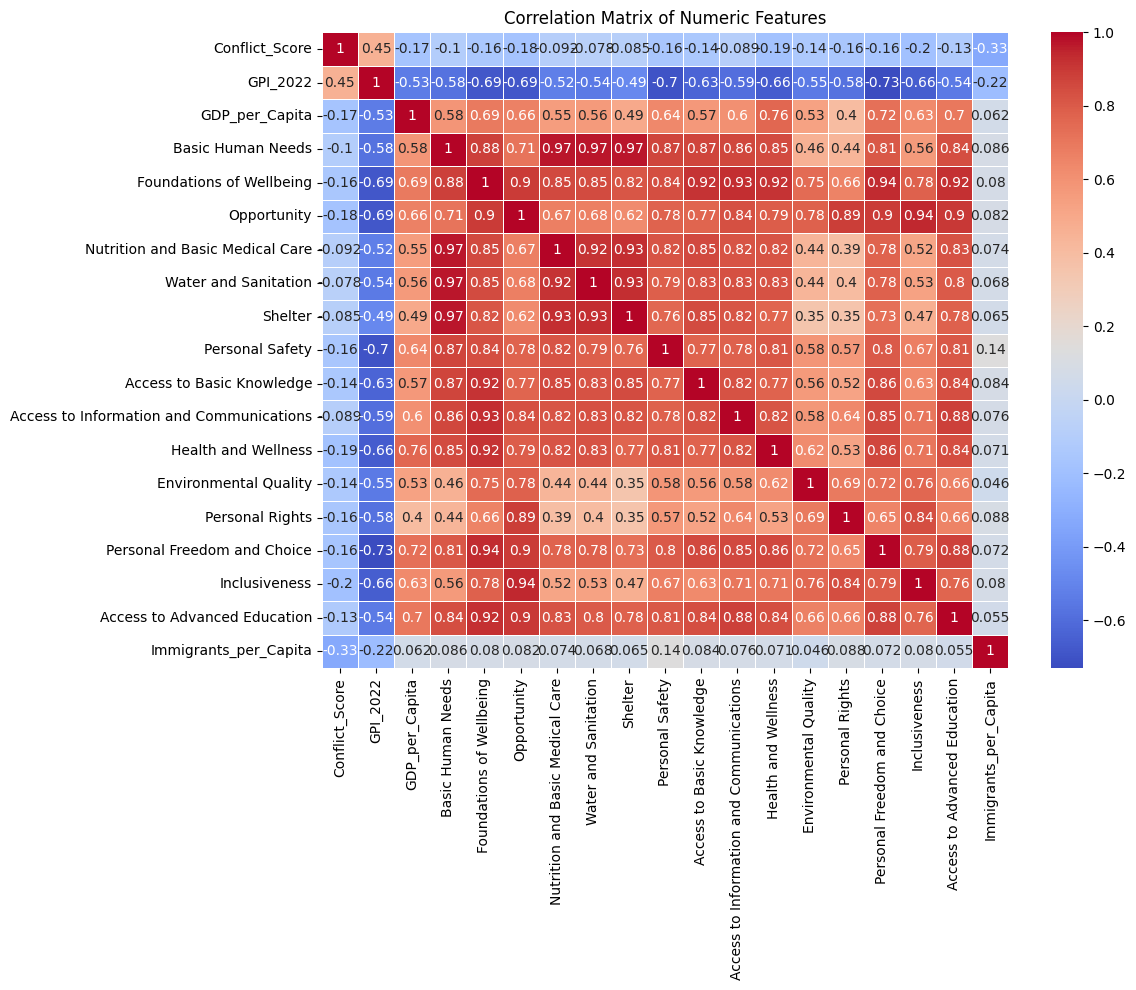

In [175]:
numeric_df = master_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Optionally, you can save the correlation matrix to a CSV file
correlation_matrix.to_csv('correlation_matrix.csv')

## Correlation Matrix Interpretation
The correlation matrix is difficult to read here but there are a few standouts:  
AECD Conflict scoring and Global Peace Index are weakly correlated. This matches up with our findings earlier in the supervised learning project
GDP per Capita and Conflict Scoring are not very strongly correlated on the inverse, while GPI and GDP have a much stronger inverse correlation
GDP is highly correlated with social progress among many dimensions, but not as much as many may assume and not in areas like "Personal Rights"
Once again, per capita immigration rates is an interesting standout. There are weak and almost evenly divided correlations across many factors. As our analyses in the last project showed, there is a qualitative difference in factors for net gain immigration countries and those with a net loss. Maybe we can expose that difference using our new tools?

## Naive K-Means

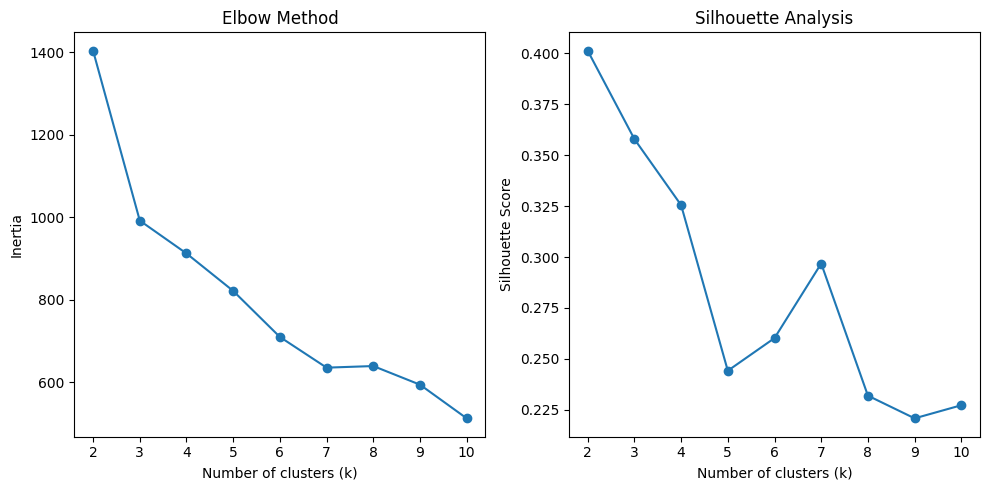


Cluster 0 characteristics:
Conflict_Score                                  0.0
GPI_2022                                        2.0
GDP_per_Capita                              10854.0
Basic Human Needs                              80.0
Foundations of Wellbeing                       67.0
Opportunity                                    56.0
Nutrition and Basic Medical Care               86.0
Water and Sanitation                           85.0
Shelter                                        85.0
Personal Safety                                63.0
Access to Basic Knowledge                      80.0
Access to Information and Communications       75.0
Health and Wellness                            59.0
Environmental Quality                          54.0
Personal Rights                                65.0
Personal Freedom and Choice                    63.0
Inclusiveness                                  43.0
Access to Advanced Education                   52.0
Immigrants_per_Capita               

In [176]:
# Select numeric columns for clustering
numeric_columns = master_df.select_dtypes(include=[np.number]).columns

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(master_df[numeric_columns])

# Determine the optimal number of clusters using the elbow method
inertias = []
silhouette_scores = []
max_clusters = 10

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

# Choose the optimal number of clusters based on the elbow method and silhouette analysis
optimal_k = 3  # You can adjust this based on the plots

# Perform k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the original DataFrame
master_df['Cluster'] = cluster_labels

# Display the first few rows of the DataFrame with cluster labels
#print(master_df[['Country', 'Cluster'] + list(numeric_columns)].head())

# Analyze cluster characteristics
for cluster in range(optimal_k):
    cluster_data = master_df[master_df['Cluster'] == cluster]
    print(f"\nCluster {cluster} characteristics:")
    print(round(cluster_data[numeric_columns].mean()),5)

## Clustering Interpretation
Our clustering looks best with a cluster of 3. This achieves a silhouette score ~.3 which is considered fairly weak. That being said, given the numbero dimensions we are analyzing here and the even greater amount of dimensions that differentiate countries in the world, we are going to continue forward with this. Lets get an intuitive idea for what kinds of countries ended up in each cluster.  

Worth highlighting here is we have two categories for countries with negative immigration and one for countries with positive immigration. The negative immigration countries appear to differ primarily by GDP per capita (by a factor of 10!), basic human needs, and infrastructure. Other progressive social scores like 'Inclusiveness' are extremely low in both. 

From this clustering, I would name these cluster colloquially as so:  
Cluster 0: Socially Regressive, Economically Advanced
Cluster 1: Socially Progressive, Economically Advanced
Cluster 2: Socially Regressive and Economically Depressed  

From this intuitive summary, can we imagine a significant category of socially progressive but economically depressed countries?

In [177]:
k_cluster_0s = master_df[master_df['Cluster'] == 0]
k_cluster_1s = master_df[master_df['Cluster'] == 1]
k_cluster_2s = master_df[master_df['Cluster'] == 2]

k_countries_0 = k_cluster_0s["Country"].tolist()
k_countries_1 = k_cluster_1s["Country"].tolist()
k_countries_2 = k_cluster_2s["Country"].tolist()

print(k_countries_0)
print(k_countries_1)
print(k_countries_2)

['Albania', 'Algeria', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'China', 'Colombia', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Gabon', 'Georgia', 'Ghana', 'Guatemala', 'Guyana', 'Honduras', 'India', 'Indonesia', 'Iraq', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kuwait', 'Lebanon', 'Malaysia', 'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Namibia', 'Nepal', 'Nicaragua', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Qatar', 'Russia', 'Saudi Arabia', 'Serbia', 'South Africa', 'Sri Lanka', 'Tajikistan', 'Thailand', 'Trinidad and Tobago', 'Tunisia', 'Turkmenistan', 'Ukraine', 'United Arab Emirates', 'Uzbekistan']
['Argentina', 'Australia', 'Austria', 'Belgium', 'Bulgaria', 'Canada', 'Chile', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Lithuania', 'Moldova

## Intuitive Interpretation
The breakdown here is very interesting. When I first was charting out this project the intuition was that countries would fall into some categories guided by three different specific cases I had in mind:  
United States / Western Europe / Japan - prototypical "advanced" countries characterized by liberal democracy and wealthy, mixed economies
China - a very advanced country with a great economy, but scores poorly on social progress metrics
Afghanistan / Rwanda / Somalia - prototypical examples of conflict prone and economically depressed countries  

Here we see that clustering does fall into three categories, though a few groupings show there is much more at play than the simplistic model outlined above. Lets keep looking

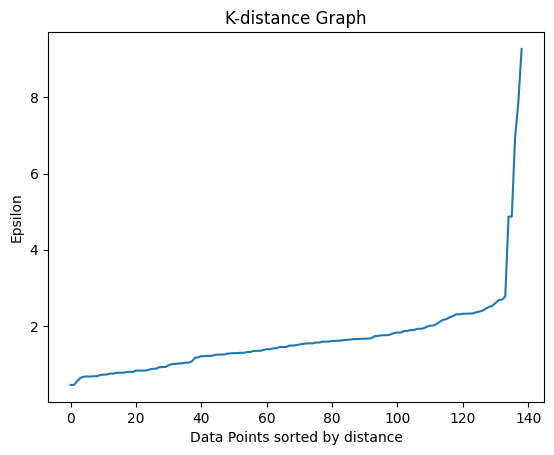

Number of clusters: 3
Number of noise points: 12


In [179]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Select numeric columns for clustering
numeric_columns = master_df.select_dtypes(include=[np.number]).columns

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(master_df[numeric_columns])

# Determine optimal epsilon using k-distance graph
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

# Choose epsilon based on the elbow in the k-distance graph
epsilon = 2.5  # Adjust this value based on the graph

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=epsilon, min_samples=3)
cluster_labels = dbscan.fit_predict(scaled_features)

# Add cluster labels to the original DataFrame
master_df['DBSCAN_Cluster'] = cluster_labels

# Display the number of clusters formed
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

## DBSCAN Comparison

In [180]:
db_cluster_0s = master_df[master_df['DBSCAN_Cluster'] == 0]
db_cluster_1s = master_df[master_df['DBSCAN_Cluster'] == 1]
db_cluster_2s = master_df[master_df['DBSCAN_Cluster'] == 2]
db_cluster_3s = master_df[master_df['DBSCAN_Cluster'] == 3]
db_cluster_4s = master_df[master_df['DBSCAN_Cluster'] == 4]
db_cluster_5s = master_df[master_df['DBSCAN_Cluster'] == 5]
db_cluster_uncat = master_df[master_df['DBSCAN_Cluster'] == -1]

db_countries_0 = db_cluster_0s["Country"].tolist()
db_countries_1 = db_cluster_1s["Country"].tolist()
db_countries_2 = db_cluster_2s["Country"].tolist()
db_countries_3 = db_cluster_3s["Country"].tolist()
db_countries_4 = db_cluster_4s["Country"].tolist()
db_countries_5 = db_cluster_5s["Country"].tolist()
db_countries_uncat = db_cluster_uncat["Country"].tolist()

print(db_countries_0)
print(db_countries_1)
print(db_countries_2)
print(db_countries_3)
print(db_countries_4)
print(db_countries_5)
print(db_countries_uncat)

['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Latvia', 'Lebanon', 'Lithuania', 'Malaysia', 'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Saudi Arabia', 'Serbia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Thailand', 'Trinidad and To

In [181]:
def common_elements(list1, list2):
    return len(set(list1).intersection(set(list2)))

print(common_elements(db_countries_0,k_countries_0))
print(common_elements(db_countries_1,k_countries_1))
print(common_elements(db_countries_2,k_countries_2))

53
0
4


We see here DBSCAN and K-Means have given us very different clusters. Maybe we need to do more to the data. Lets revise our approach with PCA and other dimensionality reduction

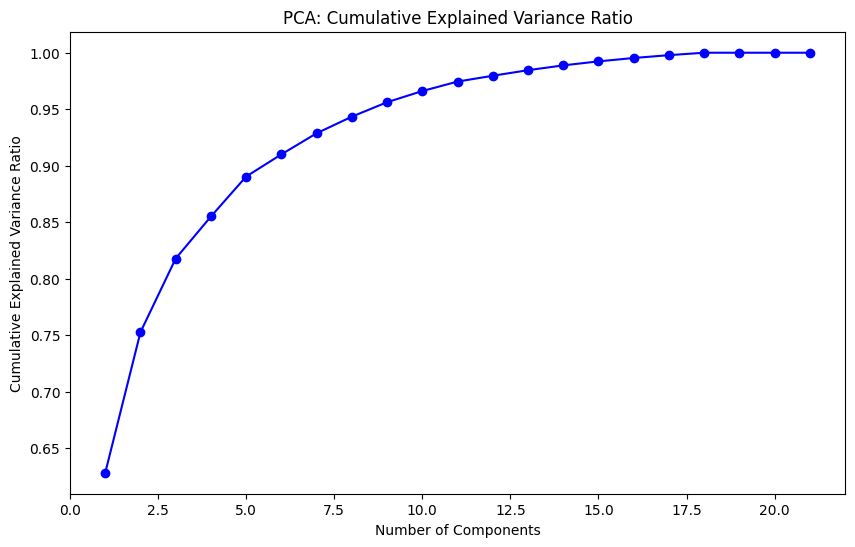

Number of components explaining 95% of variance: 9
        Country     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0   Afghanistan -6.898720 -2.375305  0.006354  1.312342  0.235839 -0.264030   
3       Albania  1.826072 -0.666318 -0.354192 -0.899599 -0.551313 -0.011883   
4       Algeria -0.027934 -1.674450 -0.681190 -0.522626  0.123096 -0.001486   
7        Angola -4.620822  1.175117 -0.541835 -0.184427  0.502818 -0.260461   
12    Argentina  2.436547  0.658472  0.345071 -0.278740 -0.779879  0.240680   

       PCA_7     PCA_8     PCA_9  
0   2.442127 -1.461529  0.397492  
3  -0.532551  0.011843  0.559161  
4   0.141585 -0.006891  0.057471  
7  -0.614453 -0.142854 -0.149974  
12  0.562736 -0.432858  0.381194  


In [182]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select numeric columns for PCA
numeric_columns = master_df.select_dtypes(include=[np.number]).columns

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(master_df[numeric_columns])

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_features)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Cumulative Explained Variance Ratio')
plt.show()

# Choose the number of components based on the explained variance ratio
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components explaining 95% of variance: {n_components}")

# Perform PCA with the chosen number of components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_features)

# Add PCA results to the original DataFrame
for i in range(n_components):
    master_df[f'PCA_{i+1}'] = pca_result[:, i]

# Display the first few rows with PCA results
print(master_df[['Country'] + [f'PCA_{i+1}' for i in range(n_components)]].head())

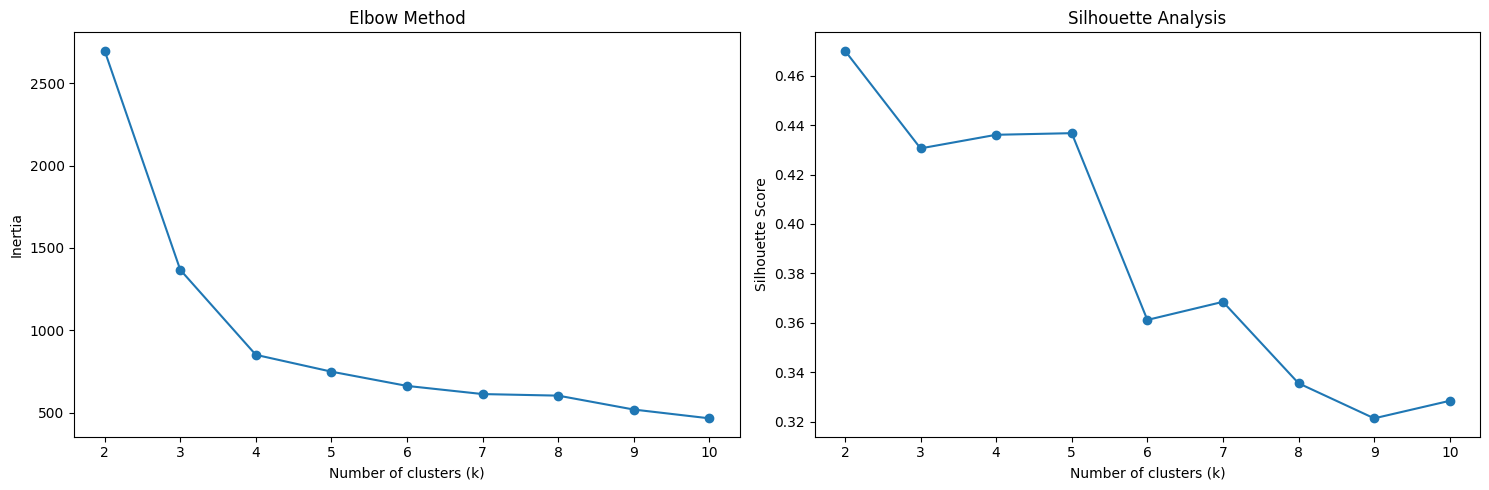

        Country  KMeans_PCA_Cluster     PCA_1     PCA_2     PCA_3     PCA_4  \
0   Afghanistan                   0 -6.898720 -2.375305  0.006354  1.312342   
3       Albania                   2  1.826072 -0.666318 -0.354192 -0.899599   
4       Algeria                   2 -0.027934 -1.674450 -0.681190 -0.522626   
7        Angola                   0 -4.620822  1.175117 -0.541835 -0.184427   
12    Argentina                   2  2.436547  0.658472  0.345071 -0.278740   

       PCA_5     PCA_6     PCA_7     PCA_8     PCA_9  
0   0.235839 -0.264030  2.442127 -1.461529  0.397492  
3  -0.551313 -0.011883 -0.532551  0.011843  0.559161  
4   0.123096 -0.001486  0.141585 -0.006891  0.057471  
7   0.502818 -0.260461 -0.614453 -0.142854 -0.149974  
12 -0.779879  0.240680  0.562736 -0.432858  0.381194  


In [183]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use the PCA results for K-Means clustering
pca_features = master_df[[f'PCA_{i+1}' for i in range(n_components)]].values

# Determine the optimal number of clusters using the elbow method and silhouette score
max_clusters = 10
inertias = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_features, kmeans.labels_))

# Plot the elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(range(2, max_clusters + 1), inertias, marker='o')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

ax2.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()

# Choose the optimal number of clusters based on the plots
optimal_k = 3  # Adjust this based on the elbow curve and silhouette scores

# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(pca_features)

# Add cluster labels to the original DataFrame
master_df['KMeans_PCA_Cluster'] = cluster_labels

# Display the first few rows with cluster labels
print(master_df[['Country', 'KMeans_PCA_Cluster'] + [f'PCA_{i+1}' for i in range(n_components)]].head())

In [184]:
k_pca_cluster_0s = master_df[master_df['KMeans_PCA_Cluster'] == 0]
k_pca_cluster_1s = master_df[master_df['KMeans_PCA_Cluster'] == 1]
k_pca_cluster_2s = master_df[master_df['KMeans_PCA_Cluster'] == 2]

k_pca_countries_0 = k_pca_cluster_0s["Country"].tolist()
k_pca_countries_1 = k_pca_cluster_1s["Country"].tolist()
k_pca_countries_2 = k_pca_cluster_2s["Country"].tolist()

print(k_pca_countries_0)
print(k_pca_countries_1)
print(k_pca_countries_2)

['Afghanistan', 'Angola', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Honduras', 'India', 'Iraq', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Nicaragua', 'Niger', 'Nigeria', 'Pakistan', 'Papua New Guinea', 'Rwanda', 'Senegal', 'Sierra Leone', 'Somalia', 'South Sudan', 'Sudan', 'Tajikistan', 'Tanzania', 'Togo', 'Turkmenistan', 'Uganda', 'Zambia', 'Zimbabwe']
['Ukraine']
['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Belarus', 'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Finland', 'Fra

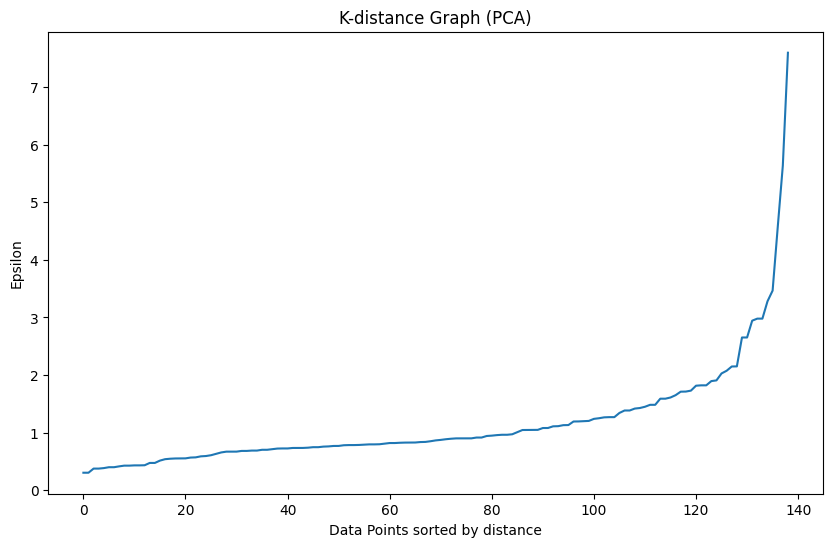

Number of clusters: 2
Number of noise points: 12


In [185]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Use the PCA results for DBSCAN clustering
pca_features = master_df[[f'PCA_{i+1}' for i in range(n_components)]].values

# Determine optimal epsilon using k-distance graph
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(pca_features)
distances, indices = neighbors_fit.kneighbors(pca_features)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph (PCA)')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

# Choose epsilon based on the elbow in the k-distance graph
epsilon = 2.7

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=epsilon, min_samples=3)
dbscan_labels = dbscan.fit_predict(pca_features)

# Add DBSCAN cluster labels to the original DataFrame
master_df['DBSCAN_PCA_Cluster'] = dbscan_labels

# Display the number of clusters formed
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

In [186]:
db_pca_cluster_0s = master_df[master_df['DBSCAN_PCA_Cluster'] == 0]
db_pca_cluster_1s = master_df[master_df['DBSCAN_PCA_Cluster'] == 1]
db_pca_cluster_2s = master_df[master_df['DBSCAN_PCA_Cluster'] == 2]
db_pca_cluster_uncat = master_df[master_df['DBSCAN_PCA_Cluster'] == -1]

db_pca_countries_0 = db_pca_cluster_0s["Country"].tolist()
db_pca_countries_1 = db_pca_cluster_1s["Country"].tolist()
db_pca_countries_2 = db_pca_cluster_2s["Country"].tolist()
db_pca_countries_uncat = db_pca_cluster_uncat["Country"].tolist()

print(db_pca_countries_0)
print(db_pca_countries_1)
print(db_pca_countries_2)
print(db_pca_countries_uncat)

['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Latvia', 'Lebanon', 'Lithuania', 'Malaysia', 'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Saudi Arabia', 'Serbia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Thailand', 'Trinidad and To

In [187]:
print(common_elements(db_pca_countries_0,k_pca_countries_0))
print(common_elements(db_pca_countries_1,k_pca_countries_1))
print(common_elements(db_pca_countries_2,k_pca_countries_2))

7
0
0


## Comparison before and after PCA
51 - 46
0 - 28
4 - 3

## Conclusion and Refinements
Categorizing countries has always been a challenging but useful activity. Human behavior and culture is a rich and complex phenenenon before considering history, geography, resources, and the relationship with neighboring countries. One important snapshot for the present state of the world's nations is net immigration outflow and inflow, and as showed in the last project there are qualitative differences between factors that influence net gain v net loss countries. Here we tried to see how far we could get out of categorizing nations out of high dimensional data, and saw that the best clustering had a single category for net gain countries and two categories for net loss countries that were mainly distinguished by GDP per capita and a few sparese social score metrics related to infrastructure. 